In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-11-28 05:00:28.119400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 05:00:28.119926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 05:00:28.192530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 05:00:29.609244: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

In [2]:


NUM_WORDS = 10000
MAXLEN = 500
BATCH_SIZE = 128
EPOCHS = 10
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:


print("Loading IMDB dataset (top {} words) ...".format(NUM_WORDS))
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print("Train samples:", len(x_train), "Test samples:", len(x_test))

Loading IMDB dataset (top 10000 words) ...


Train samples: 25000 Test samples: 25000


In [4]:


x_train = pad_sequences(x_train, maxlen=MAXLEN, padding='pre', truncating='pre')
x_test = pad_sequences(x_test, maxlen=MAXLEN, padding='pre', truncating='pre')

# Create a validation split from training set
VAL_SPLIT = 0.2
num_val = int(len(x_train) * VAL_SPLIT)
x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train_sub = x_train[num_val:]
y_train_sub = y_train[num_val:]

print("After padding:")
print("x_train_sub:", x_train_sub.shape, "x_val:", x_val.shape, "x_test:", x_test.shape)

After padding:
x_train_sub: (20000, 500) x_val: (5000, 500) x_test: (25000, 500)


In [5]:

def build_simple_rnn_model(num_words=NUM_WORDS, emb_dim=128, rnn_units=128, input_len=MAXLEN):
    """Class model: Embedding 128 + SimpleRNN(128) + Dense(1, sigmoid)"""
    inputs = layers.Input(shape=(input_len,), dtype='int32')
    x = layers.Embedding(input_dim=num_words, output_dim=emb_dim, input_length=input_len)(inputs)
    x = layers.SimpleRNN(rnn_units)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name="SimpleRNN_model")
    return model


def build_lstm_model(num_words=NUM_WORDS, emb_dim=64, lstm_units=64, input_len=MAXLEN):
    """My model: Embedding 64 + LSTM(64) + Dense(1, sigmoid)"""
    inputs = layers.Input(shape=(input_len,), dtype='int32')
    x = layers.Embedding(input_dim=num_words, output_dim=emb_dim, input_length=input_len)(inputs)
    x = layers.LSTM(lstm_units)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name="LSTM_model")
    return model

In [6]:
# ------------------ Compile models ------------------
print("\nBuilding models...")
simple_rnn = build_simple_rnn_model()
lstm = build_lstm_model()

for m in (simple_rnn, lstm):
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    m.summary()  # prints model summary


Building models...


/home/jerit/ml/movie-review-classifier/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-28 05:00:35.113387: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "SimpleRNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,025 (5.01 MB)

 Trainable params: 1,313,025 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 500, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [8]:
# ------------------ Train SimpleRNN (class model) ------------------
print("\nTraining SimpleRNN (class model) ...")
rnn_ckpt = os.path.join(MODEL_DIR, "simple_rnn_best.h5")
rnn_cp = ModelCheckpoint(rnn_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1)

history_rnn = simple_rnn.fit(
    x_train_sub, y_train_sub,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    callbacks=[es, reduce_lr, rnn_cp],
    verbose=2
)




Training SimpleRNN (class model) ...


Epoch 1/10

Epoch 1: val_accuracy improved from None to 0.63660, saving model to saved_models/simple_rnn_best.h5


157/157 - 33s - 213ms/step - accuracy: 0.5846 - loss: 0.6581 - val_accuracy: 0.6366 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy improved from 0.63660 to 0.70680, saving model to saved_models/simple_rnn_best.h5


157/157 - 29s - 182ms/step - accuracy: 0.7843 - loss: 0.4596 - val_accuracy: 0.7068 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy improved from 0.70680 to 0.81620, saving model to saved_models/simple_rnn_best.h5


157/157 - 29s - 187ms/step - accuracy: 0.9190 - loss: 0.2109 - val_accuracy: 0.8162 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.81620
157/157 - 28s - 176ms/step - accuracy: 0.9803 - loss: 0.0648 - val_accuracy: 0.7782 - val_loss: 0.6326 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy improved from 0.81620 to 0.82360, saving model to saved_models/simple_rnn_best.h5


157/157 - 29s - 184ms/step - accuracy: 0.9941 - loss: 0.0236 - val_accuracy: 0.8236 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.82360
157/157 - 28s - 178ms/step - accuracy: 0.9987 - loss: 0.0082 - val_accuracy: 0.7910 - val_loss: 0.7401 - learning_rate: 5.0000e-04


In [9]:
# ------------------ Train LSTM (your model) ------------------
print("\nTraining LSTM (your model) ...")
lstm_ckpt = os.path.join(MODEL_DIR, "lstm_best.h5")
lstm_cp = ModelCheckpoint(lstm_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1)

history_lstm = lstm.fit(
    x_train_sub, y_train_sub,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    callbacks=[es, reduce_lr, lstm_cp],
    verbose=2
)


Training LSTM (your model) ...
Epoch 1/10

Epoch 1: val_accuracy improved from None to 0.86760, saving model to saved_models/lstm_best.h5


157/157 - 57s - 362ms/step - accuracy: 0.7674 - loss: 0.4719 - val_accuracy: 0.8676 - val_loss: 0.3199 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy improved from 0.86760 to 0.88460, saving model to saved_models/lstm_best.h5


157/157 - 54s - 346ms/step - accuracy: 0.8916 - loss: 0.2795 - val_accuracy: 0.8846 - val_loss: 0.2953 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.88460
157/157 - 55s - 352ms/step - accuracy: 0.9179 - loss: 0.2174 - val_accuracy: 0.8706 - val_loss: 0.3269 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.88460
157/157 - 53s - 340ms/step - accuracy: 0.9445 - loss: 0.1535 - val_accuracy: 0.8786 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.88460
157/157 - 48s - 309ms/step - accuracy: 0.9664 - loss: 0.1042 - val_accuracy: 0.8826 - val_loss: 0.3581 - learning_rate: 5.0000e-04


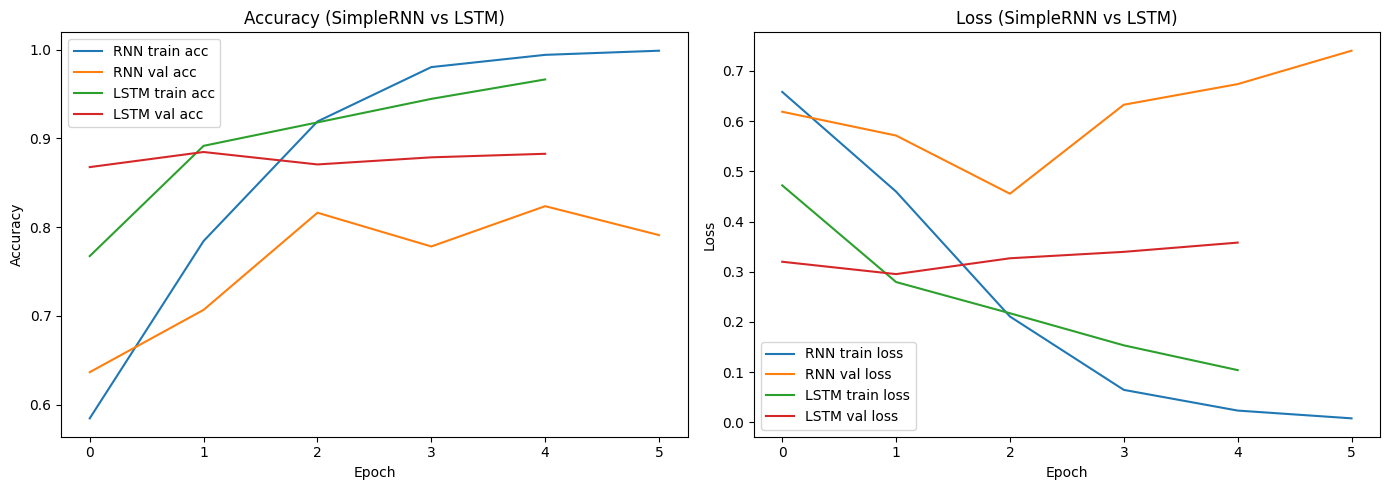

In [10]:
# ------------------ Plot training curves ------------------
def plot_history(h1, h2, title_suffix=""):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'], label='RNN train acc')
    plt.plot(h1.history['val_accuracy'], label='RNN val acc')
    plt.plot(h2.history['accuracy'], label='LSTM train acc')
    plt.plot(h2.history['val_accuracy'], label='LSTM val acc')
    plt.title('Accuracy ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'], label='RNN train loss')
    plt.plot(h1.history['val_loss'], label='RNN val loss')
    plt.plot(h2.history['loss'], label='LSTM train loss')
    plt.plot(h2.history['val_loss'], label='LSTM val loss')
    plt.title('Loss ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_rnn, history_lstm, title_suffix="(SimpleRNN vs LSTM)")

In [11]:
word_index = imdb.get_word_index()
reverse_word_index = {value+3: key for (key, value) in word_index.items()}
reverse_word_index[0] = '<PAD>'
reverse_word_index[1] = '<START>'
reverse_word_index[2] = '<UNK>'
reverse_word_index[3] = 'the'

def decode_review(seq):
    return ' '.join([reverse_word_index.get(i, '?') for i in seq if i != 0])

In [12]:
print('\n=== 5 Sample test reviews and predictions (LSTM) ===')
for i in range(5):
    seq = x_test[i]
    text = decode_review(seq)
    prob = lstm.predict(np.array([seq]), verbose=0)[0,0]
    pred = 'Positive' if prob >= 0.5 else 'Negative'
    actual = 'Positive' if y_test[i] == 1 else 'Negative'
    print('\n--- Sample %d ---' % (i+1))
    print('Actual:', actual)
    print('Predicted: %s (prob=%.4f)' % (pred, prob))
    print('Review (truncated):', text[:600], '...\n')


=== 5 Sample test reviews and predictions (LSTM) ===

--- Sample 1 ---
Actual: Negative
Predicted: Negative (prob=0.1302)
Review (truncated): <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss ...


--- Sample 2 ---
Actual: Positive
Predicted: Positive (prob=0.9789)
Review (truncated): <START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNK> the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere <UNK> with sexual tension and psychological <UNK> it's very interesting that robert altman directed thi

In [13]:
# ------------------ Evaluation on Test Set ------------------
print("\nEvaluating on test set ...")
rnn_test_loss, rnn_test_acc = simple_rnn.evaluate(x_test, y_test, verbose=2)
lstm_test_loss, lstm_test_acc = lstm.evaluate(x_test, y_test, verbose=2)

print("\nFinal test accuracy:")
print(f"SimpleRNN test accuracy: {rnn_test_acc*100:.2f}% (loss {rnn_test_loss:.4f})")
print(f"LSTM      test accuracy: {lstm_test_acc*100:.2f}% (loss {lstm_test_loss:.4f})")


Evaluating on test set ...
782/782 - 19s - 24ms/step - accuracy: 0.8108 - loss: 0.4695
782/782 - 28s - 36ms/step - accuracy: 0.8712 - loss: 0.3135

Final test accuracy:
SimpleRNN test accuracy: 81.08% (loss 0.4695)
LSTM      test accuracy: 87.12% (loss 0.3135)
